In [1]:
import torch
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data import DataLoader

import helper
from unet.models.unet import UNet
from unet.utils.dataset import TiffDataset
from unet.utils.transformers import MicroTransformers

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
torch.device(device)
print("Using device:", device)

Using device: mps


In [2]:
val_image_path = "data/png/test/image"
val_masks_path = "data/png/test/label"

raw_dataset = TiffDataset(image_path=val_image_path,masks_path=val_masks_path,transforms=MicroTransformers(geo_augment=False,denoise=False))
denoise_dataset = TiffDataset(image_path=val_image_path,masks_path=val_masks_path,transforms=MicroTransformers(geo_augment=False,denoise=True))


raw_loader = DataLoader(raw_dataset, batch_size=4, shuffle=False, in_order=True)
denoise_loader = DataLoader(denoise_dataset, batch_size=4, shuffle=False,in_order=True)

Found 4  (image, mask) pairs
Found 4  (image, mask) pairs


In [3]:
unet_model_path = helper.download_model("https://github.com/maocili/Group15_Project21_02456/releases/download/v0.0.1/U-Net_w_km_trainning_log.pth","models")

unet_denoise_model_path = helper.download_model("https://github.com/maocili/Group15_Project21_02456/releases/download/v0.0.1/best_iou_Standard_km_pxiel_20251202_014629.pth","models")

mt_denoise_model_path = helper.download_model("https://github.com/maocili/Group15_Project21_02456/releases/download/v0.0.1/best_iou_MT_Teacher_mt_pxiel_20251202_020501.pth","models")

mt_normal_model_path = helper.download_model("https://github.com/maocili/Group15_Project21_02456/releases/download/v0.0.1/best_iou_MT_Teacher_mt_20251202_022352.pth","models")

mt_with_unlabeled_data_path = helper.download_model("https://github.com/maocili/Group15_Project21_02456/releases/download/v0.0.1/best_iou_MT_Teacher_U-Net_20251203_075452.pth")


File 'U-Net_w_km_trainning_log.pth' already exists. Skipping download.
File 'best_iou_Standard_km_pxiel_20251202_014629.pth' already exists. Skipping download.
File 'best_iou_MT_Teacher_mt_pxiel_20251202_020501.pth' already exists. Skipping download.
File 'best_iou_MT_Teacher_mt_20251202_022352.pth' already exists. Skipping download.
File 'best_iou_MT_Teacher_U-Net_20251203_075452.pth' already exists. Skipping download.


In [4]:
unet_train_log_path = "training_log/U-Net_w_km_trainning_log.csv"
unet_denoise_train_log_path = "training_log/training_km_pxiel_log_20251202_014629.csv"

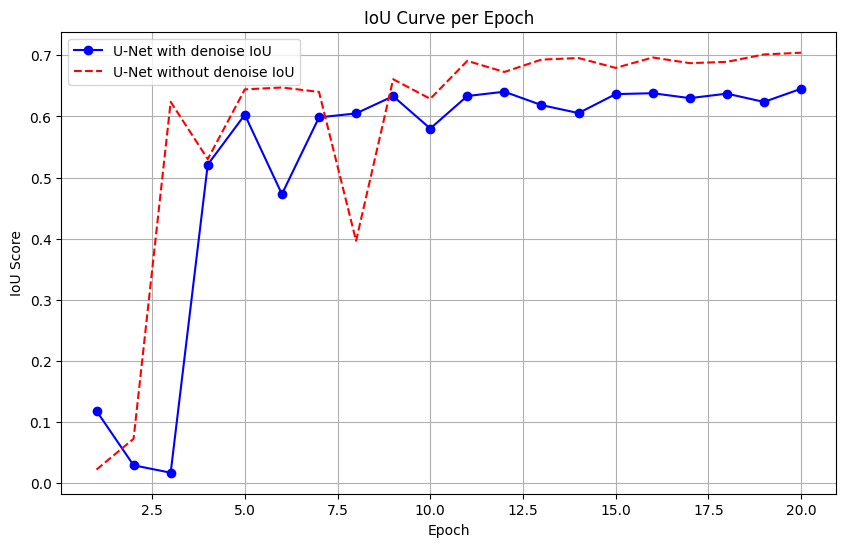

In [5]:
train_log = pd.read_csv(unet_train_log_path)
denoise_log = pd.read_csv(unet_denoise_train_log_path)

plt.figure(figsize=(10, 6))
plt.plot(denoise_log['Epoch'], denoise_log['Val_IoU'], label='U-Net with denoise IoU', color='blue', marker='o', linestyle='-')
plt.plot(train_log['Epoch'], train_log['Val_IoU'], label='U-Net without denoise IoU', color='red', linestyle='--')

plt.title('IoU Curve per Epoch')
plt.xlabel('Epoch')
plt.ylabel('IoU Score')

plt.legend()
plt.grid(True)

plt.show()

In [6]:
normal_model = UNet(in_channels=1, out_channels=2).to(device)
normal_model.load_state_dict(torch.load(unet_model_path, map_location=device, weights_only=True))

baseline_model = UNet(in_channels=1, out_channels=2).to(device)
baseline_model.load_state_dict(torch.load(unet_denoise_model_path, map_location=device, weights_only=True))

mt_normal_model = UNet(in_channels=1, out_channels=2).to(device)
mt_normal_model.load_state_dict(torch.load(mt_normal_model_path, map_location=device, weights_only=True))

mt_denoise_model = UNet(in_channels=1, out_channels=2).to(device)
mt_denoise_model.load_state_dict(torch.load(mt_denoise_model_path, map_location=device, weights_only=True))

mt_denoise_with_unlabeled_model = UNet(in_channels=1,out_channels=2).to(device)
mt_denoise_with_unlabeled_model.load_state_dict(torch.load(mt_with_unlabeled_data_path, map_location=device, weights_only=True))


<All keys matched successfully>

torch.Size([3, 1, 768, 768]) torch.Size([3, 1, 768, 768])
Visualizing combined batch size: 3 (3 from A, 3 from B)
Figure saved to dual_loader_comparison.png


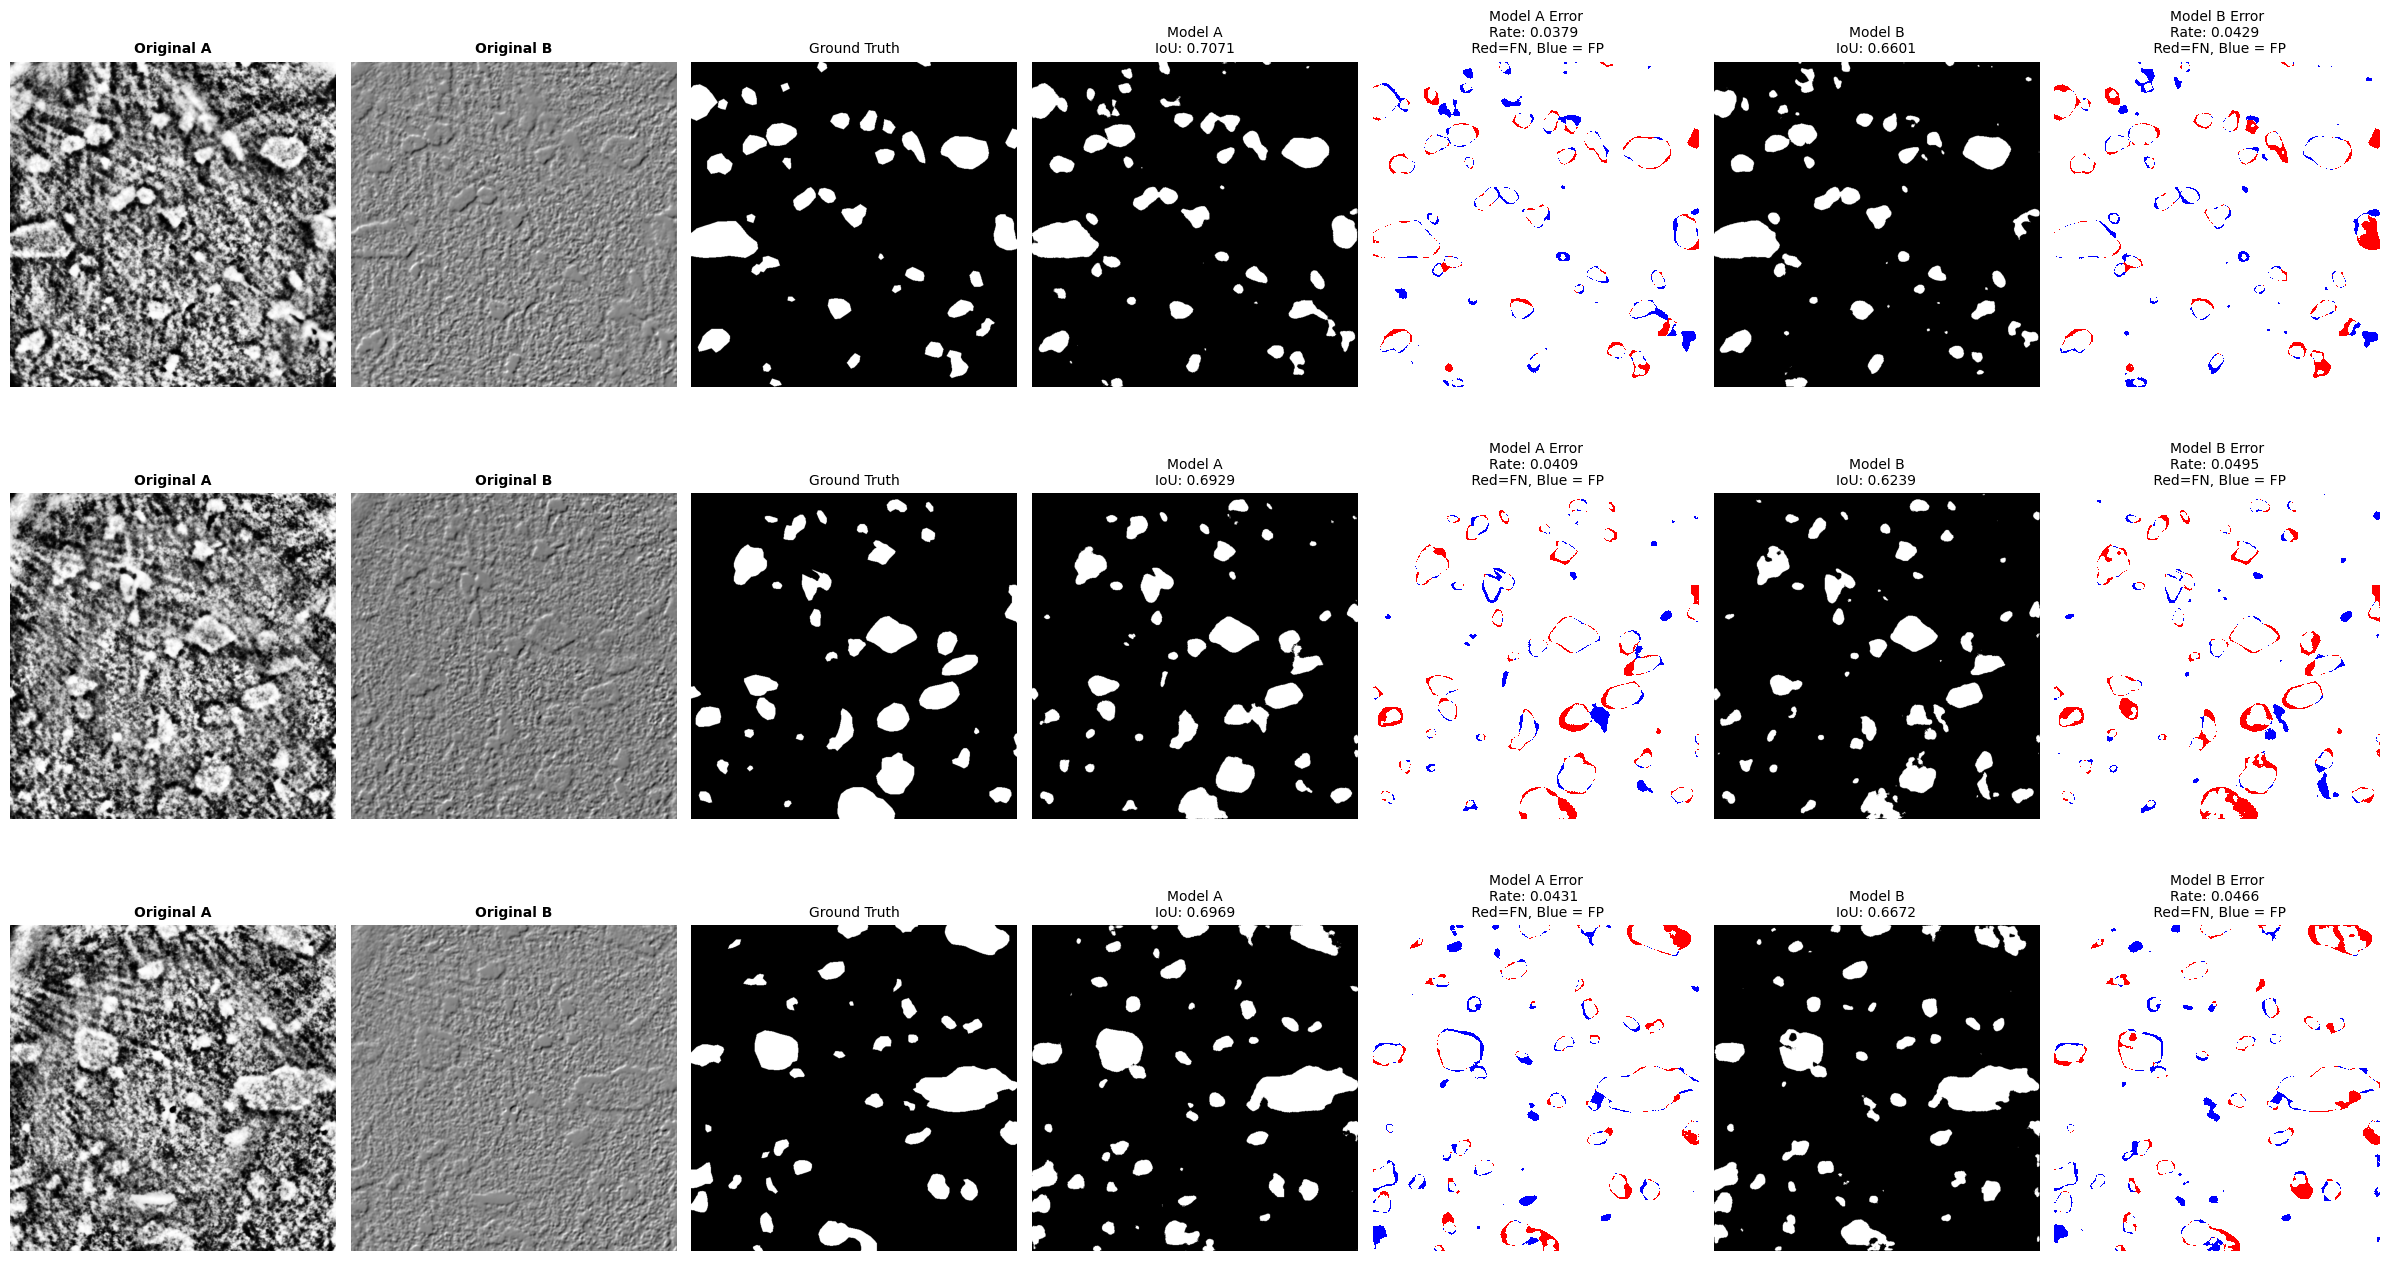

In [7]:
# Compare the performance of the U-Net model with and without denoising.
helper.visualize_comparison_validation(loader_A=raw_loader,loader_B=denoise_loader, device=device,model_A=normal_model,model_B=baseline_model)

torch.Size([3, 1, 768, 768]) torch.Size([3, 1, 768, 768])
Visualizing combined batch size: 3 (3 from A, 3 from B)
Figure saved to dual_loader_comparison.png


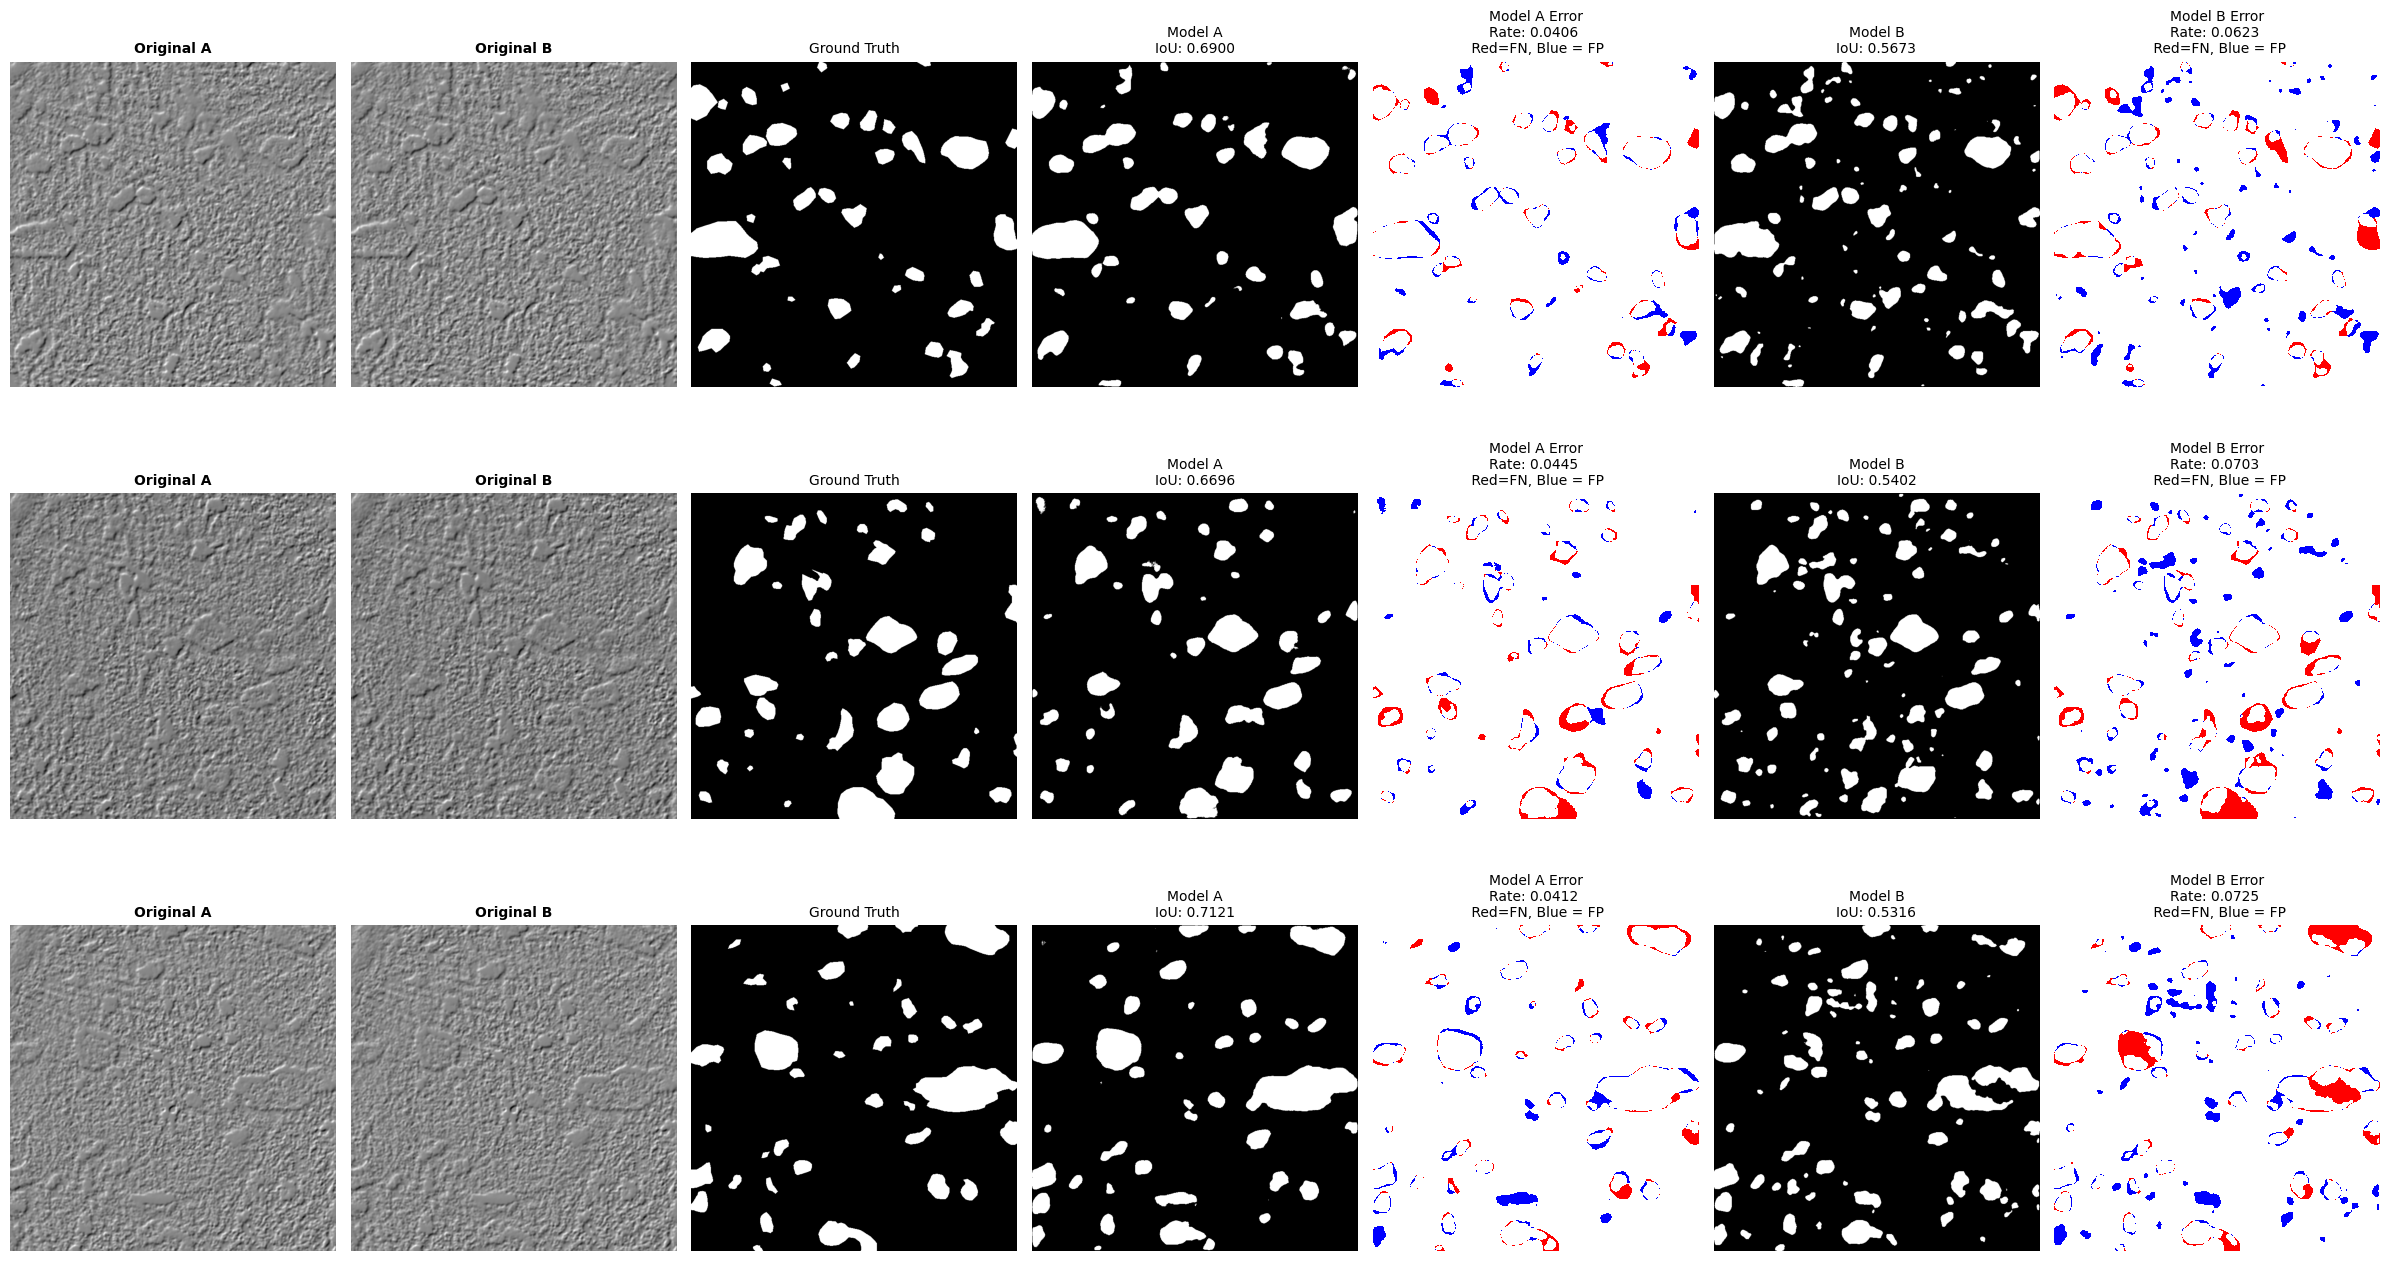

In [8]:
# Compare the U-Net model trained with the Mean Teacher method using only labeled data and using both labeled and unlabeled data.
helper.visualize_comparison_validation(loader_A=denoise_loader, loader_B=denoise_loader,
                                       device=device, model_A=mt_denoise_model, model_B=mt_denoise_with_unlabeled_model)

# Compare different Loss Functions

File 'best_iou_Standard_loss_ce_20251202_033557.pth' already exists. Skipping download.
torch.Size([3, 1, 768, 768]) torch.Size([3, 1, 768, 768])
Visualizing combined batch size: 3 (3 from A, 3 from B)
Figure saved to dual_loader_comparison.png


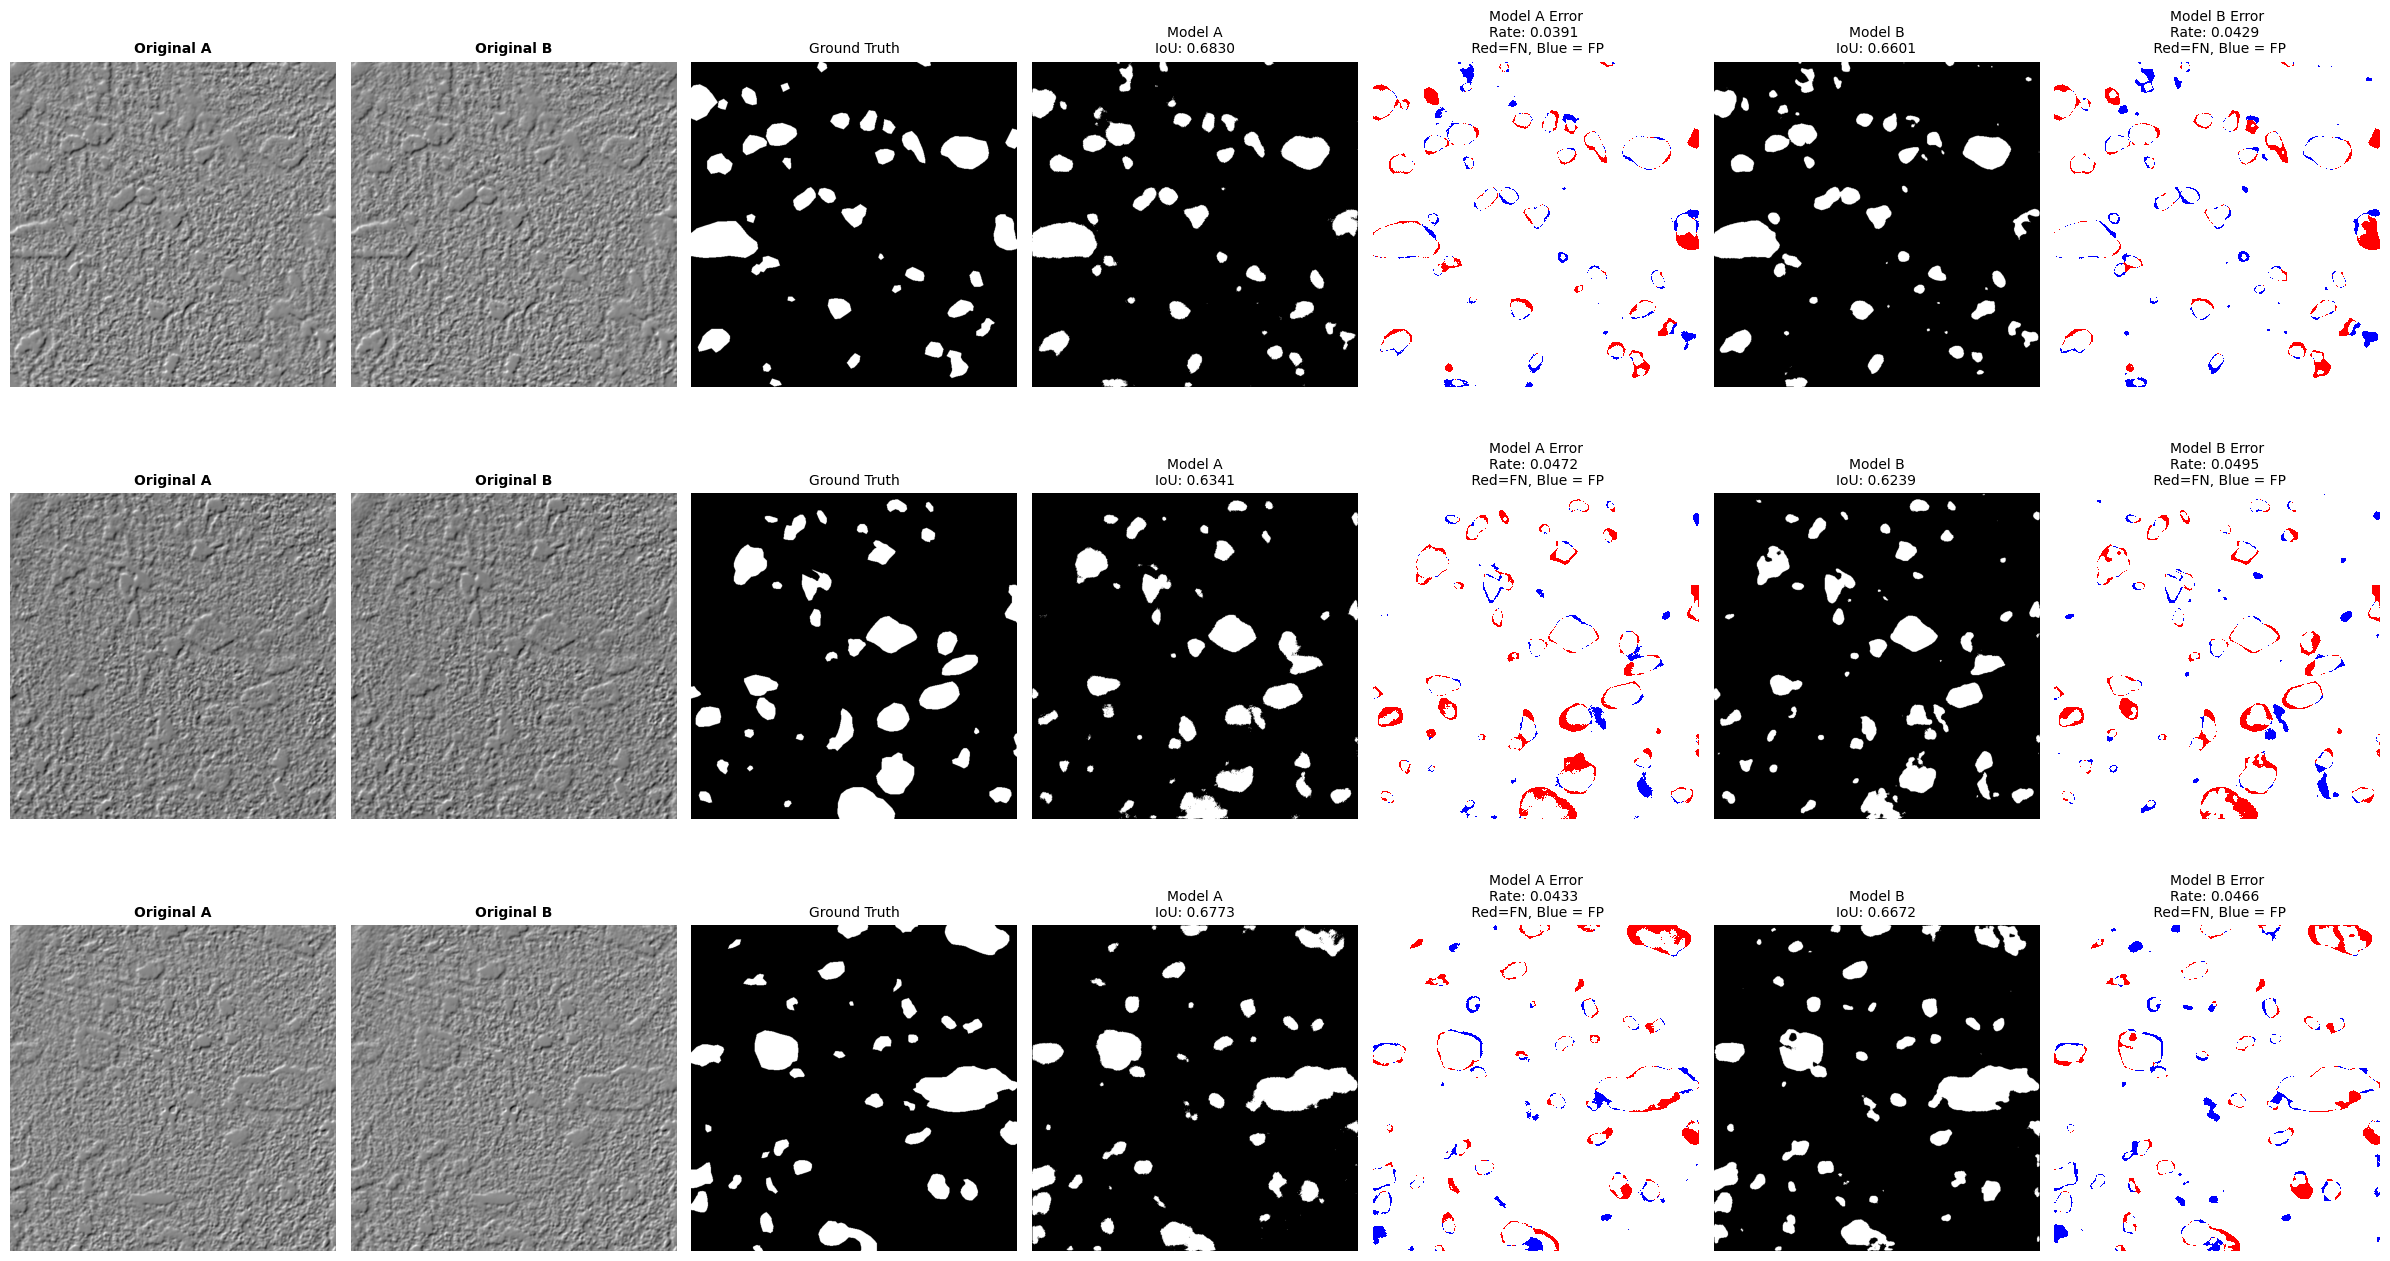

In [9]:
# CE vs Baseline
url = "https://github.com/maocili/Group15_Project21_02456/releases/download/v0.0.1/best_iou_Standard_loss_ce_20251202_033557.pth"
ce_unet_model_path = helper.download_model(url)

ce_unet = UNet(in_channels=1, out_channels=2).to(device)
ce_unet.load_state_dict(torch.load(ce_unet_model_path, map_location=device, weights_only=True))

helper.visualize_comparison_validation(loader_A=denoise_loader, loader_B=denoise_loader,
                                       device=device, model_A=ce_unet, model_B=baseline_model)

File 'best_iou_Standard_loss_ce_dice_20251202_034620.pth' already exists. Skipping download.
torch.Size([3, 1, 768, 768]) torch.Size([3, 1, 768, 768])
Visualizing combined batch size: 3 (3 from A, 3 from B)
Figure saved to dual_loader_comparison.png


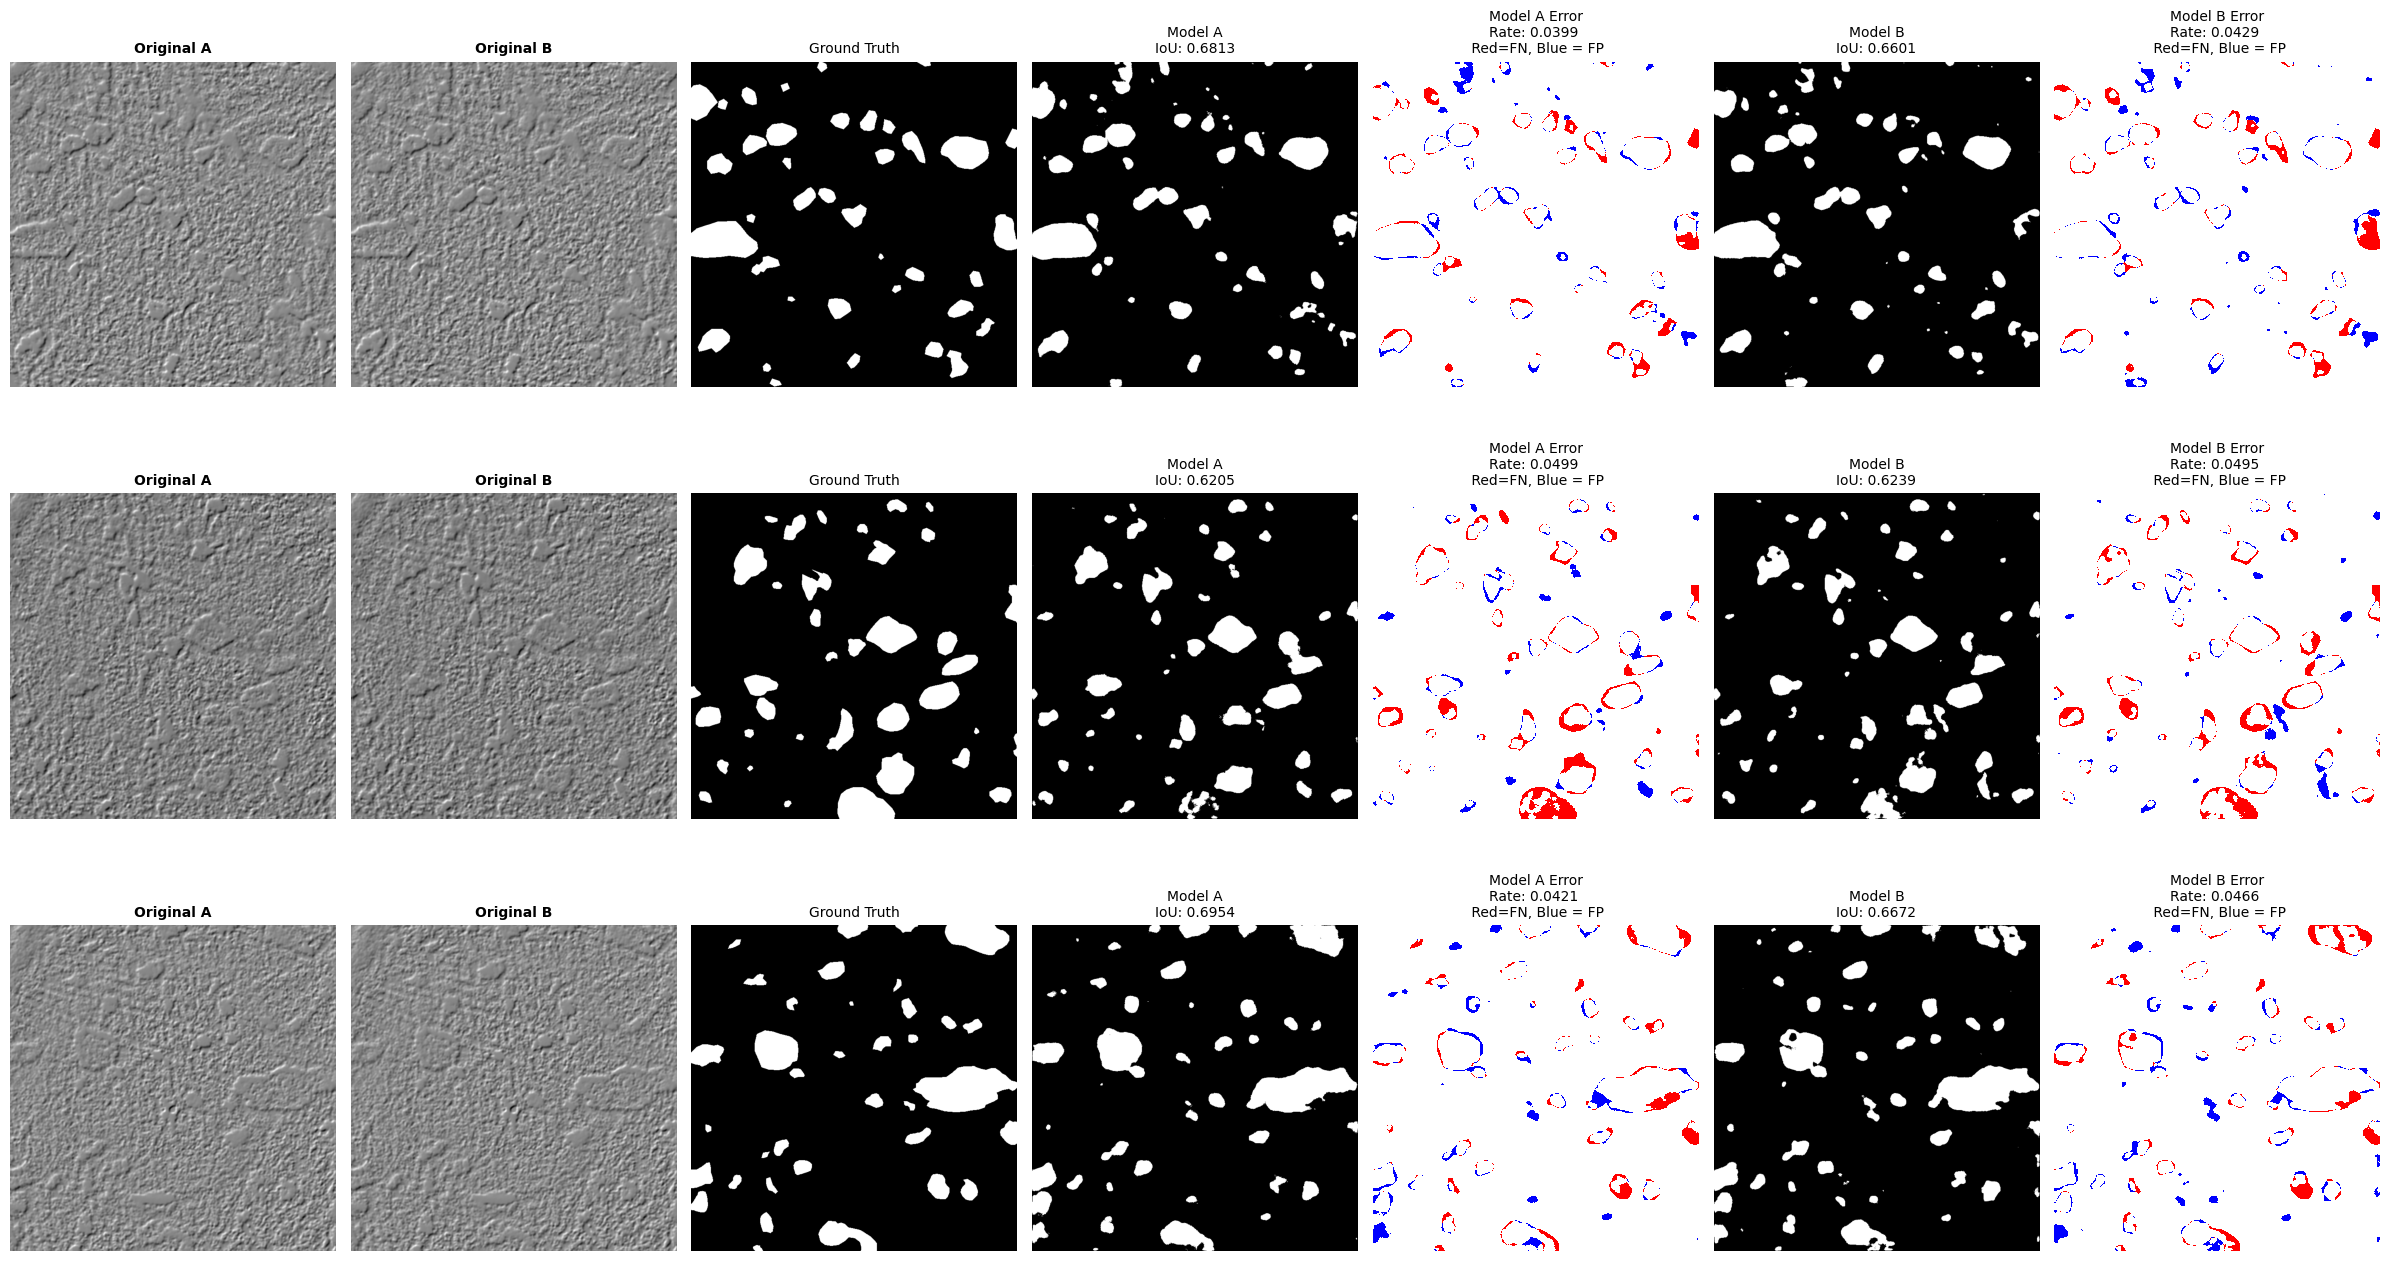

In [10]:
# CE + Dice Loss vs 
url = "https://github.com/maocili/Group15_Project21_02456/releases/download/v0.0.1/best_iou_Standard_loss_ce_dice_20251202_034620.pth"
ce_dice_unet_path = helper.download_model(url)

ce_dice_unet = UNet(in_channels=1, out_channels=2).to(device)
ce_dice_unet.load_state_dict(torch.load(ce_dice_unet_path, map_location=device, weights_only=True))

helper.visualize_comparison_validation(loader_A=denoise_loader, loader_B=denoise_loader,
                                       device=device, model_A=ce_dice_unet, model_B=baseline_model)

File 'best_iou_Standard_loss_ce_logdice_20251202_040133.pth' already exists. Skipping download.
torch.Size([3, 1, 768, 768]) torch.Size([3, 1, 768, 768])
Visualizing combined batch size: 3 (3 from A, 3 from B)
Figure saved to dual_loader_comparison.png


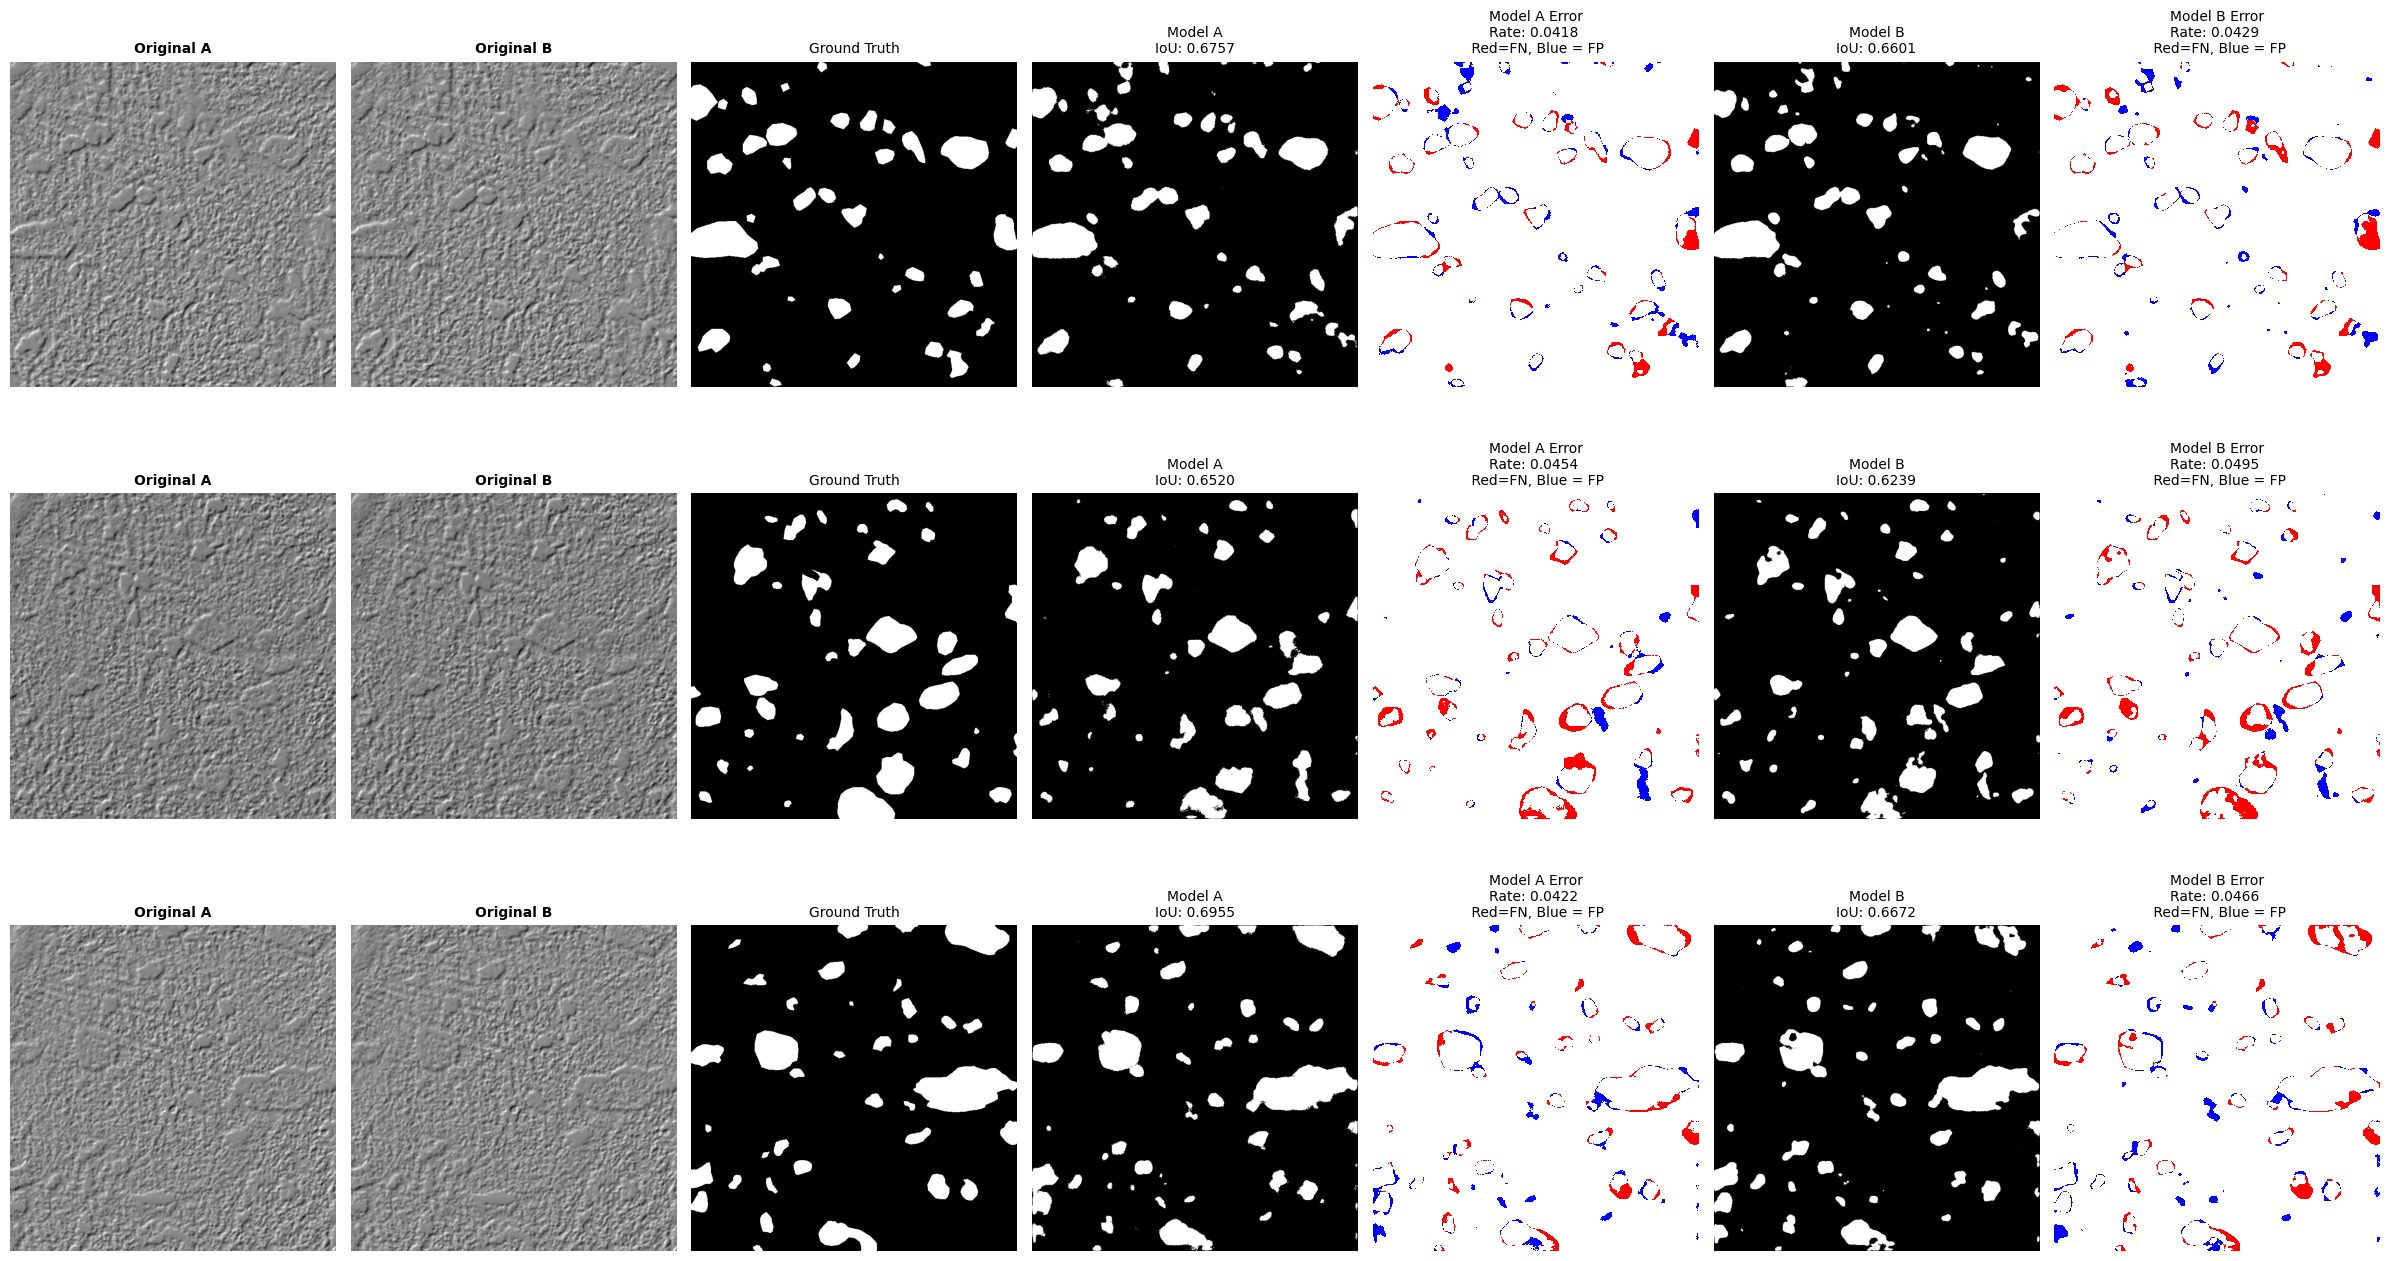

In [11]:
# Focal + Logdice vs Baseline
url = "https://github.com/maocili/Group15_Project21_02456/releases/download/v0.0.1/best_iou_Standard_loss_ce_logdice_20251202_040133.pth"
f_dice_unet_path = helper.download_model(url)

f_dice_unet = UNet(in_channels=1, out_channels=2).to(device)
f_dice_unet.load_state_dict(torch.load(f_dice_unet_path, map_location=device, weights_only=True))

helper.visualize_comparison_validation(loader_A=denoise_loader, loader_B=denoise_loader,
                                       device=device, model_A=f_dice_unet, model_B=baseline_model)

File 'best_iou_Standard_dice_20251202_040325.pth' already exists. Skipping download.
torch.Size([3, 1, 768, 768]) torch.Size([3, 1, 768, 768])
Visualizing combined batch size: 3 (3 from A, 3 from B)
Figure saved to dual_loader_comparison.png


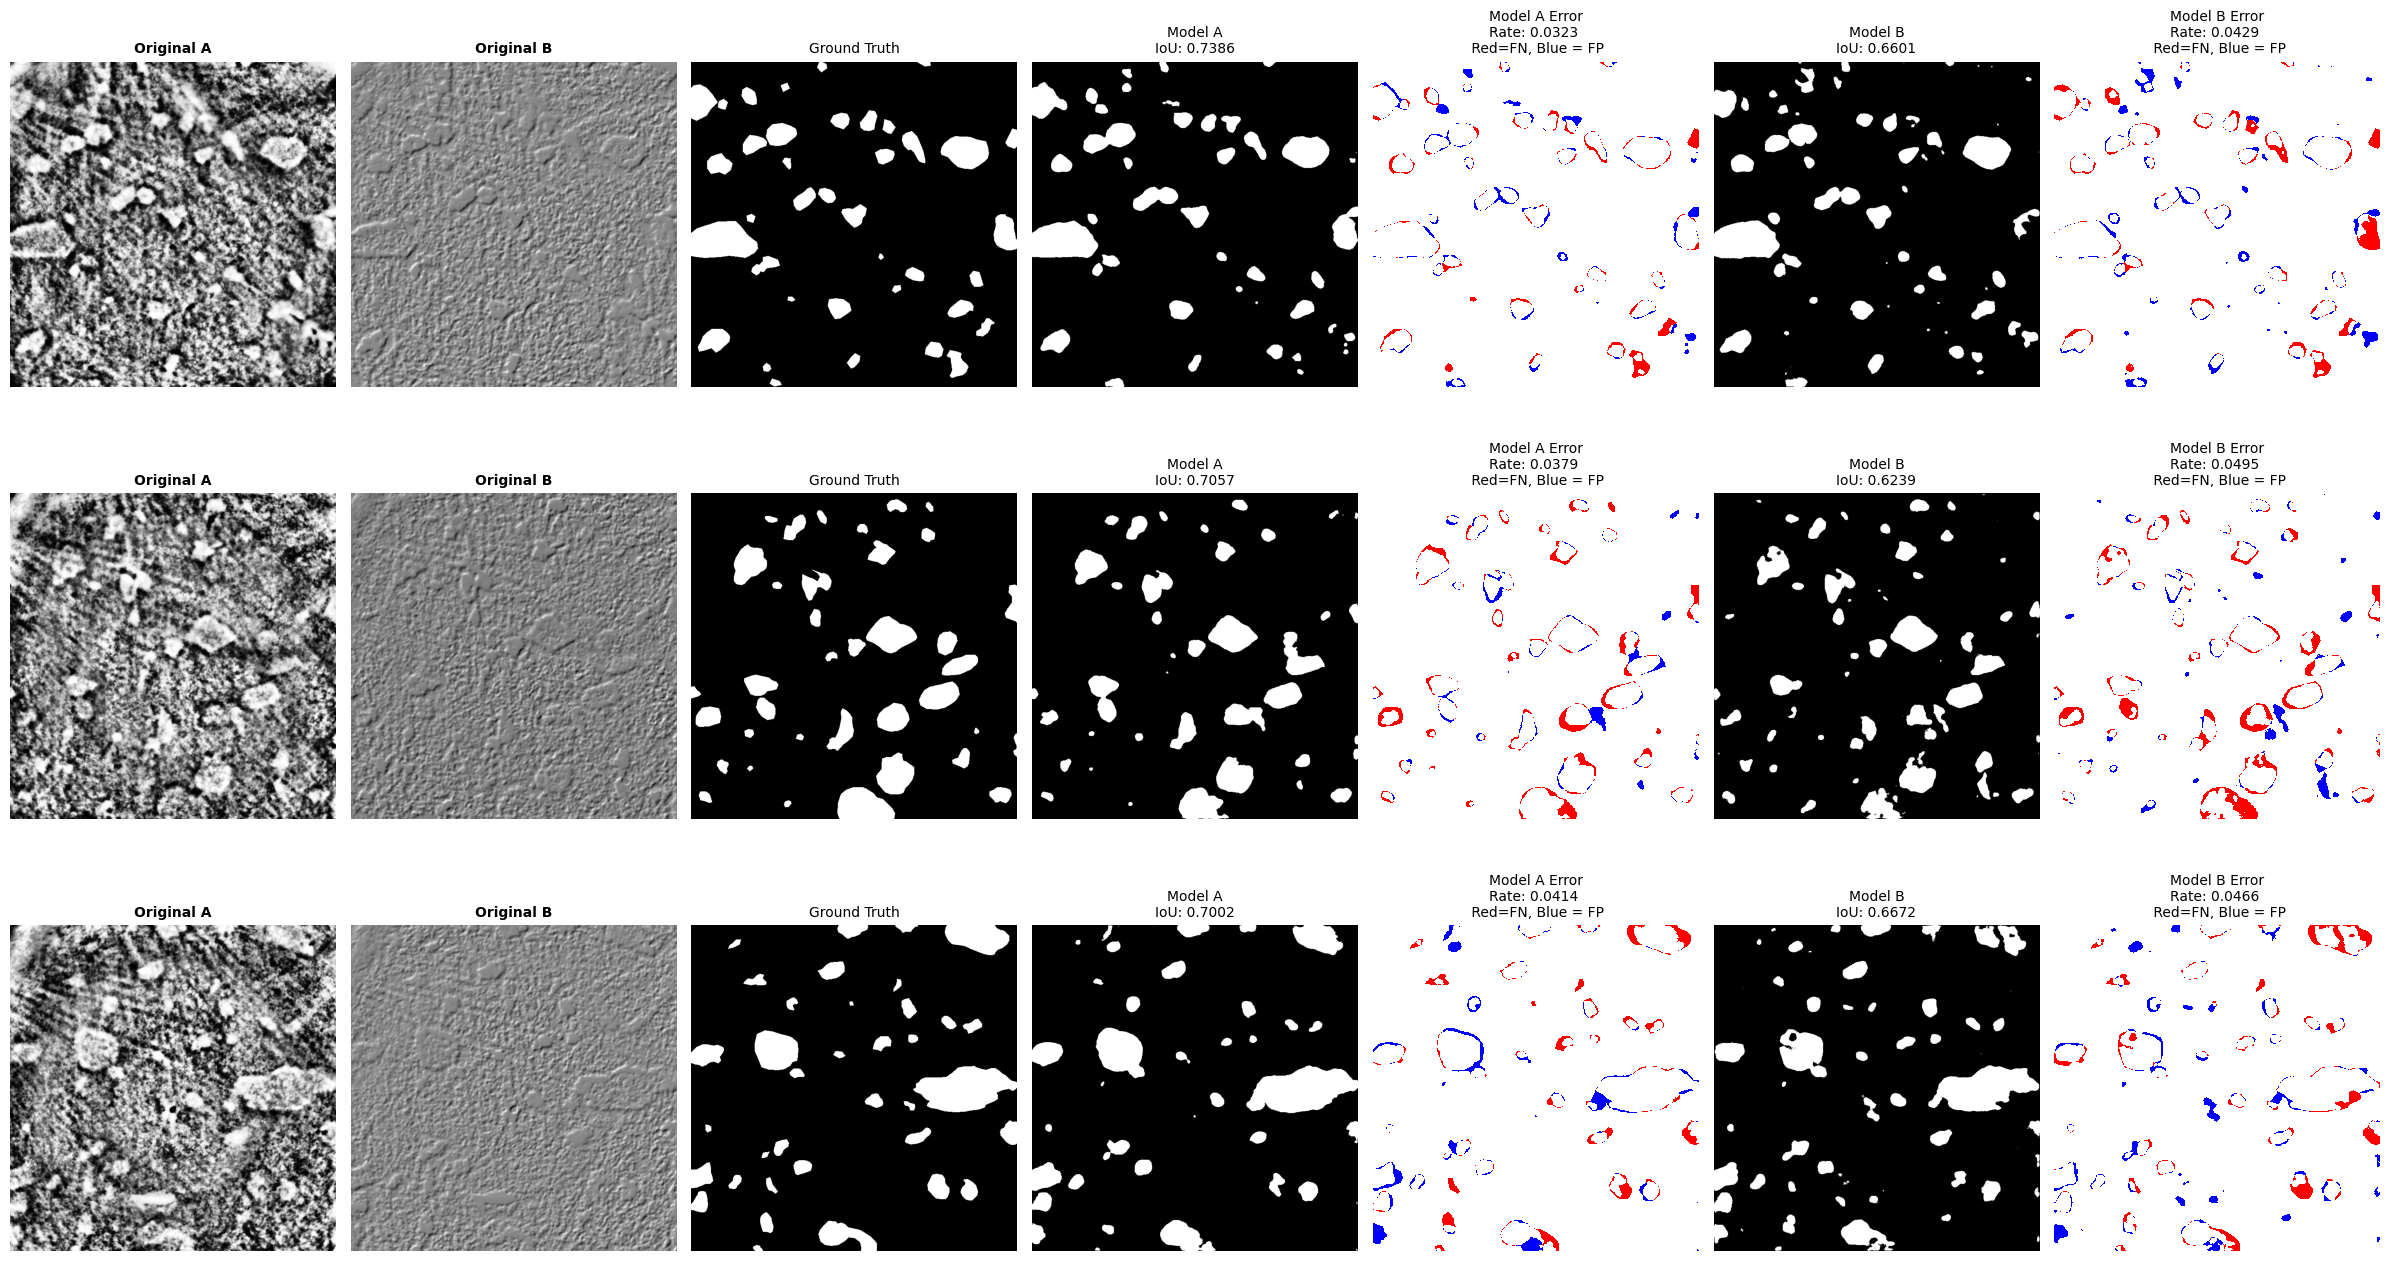

In [12]:
# Dice vs Baseline
url = "https://github.com/maocili/Group15_Project21_02456/releases/download/v0.0.1/best_iou_Standard_dice_20251202_040325.pth"
dice_unet_path = helper.download_model(url)

dice_unet = UNet(in_channels=1, out_channels=2).to(device)
dice_unet.load_state_dict(torch.load(dice_unet_path, map_location=device, weights_only=True))

helper.visualize_comparison_validation(loader_A=raw_loader, loader_B=denoise_loader,
                                       device=device, model_A=dice_unet, model_B=baseline_model)

File 'best_iou_Standard_loss_f_t_0.3_0.7_20251202_041128.pth' already exists. Skipping download.
torch.Size([3, 1, 768, 768]) torch.Size([3, 1, 768, 768])
Visualizing combined batch size: 3 (3 from A, 3 from B)
Figure saved to dual_loader_comparison.png


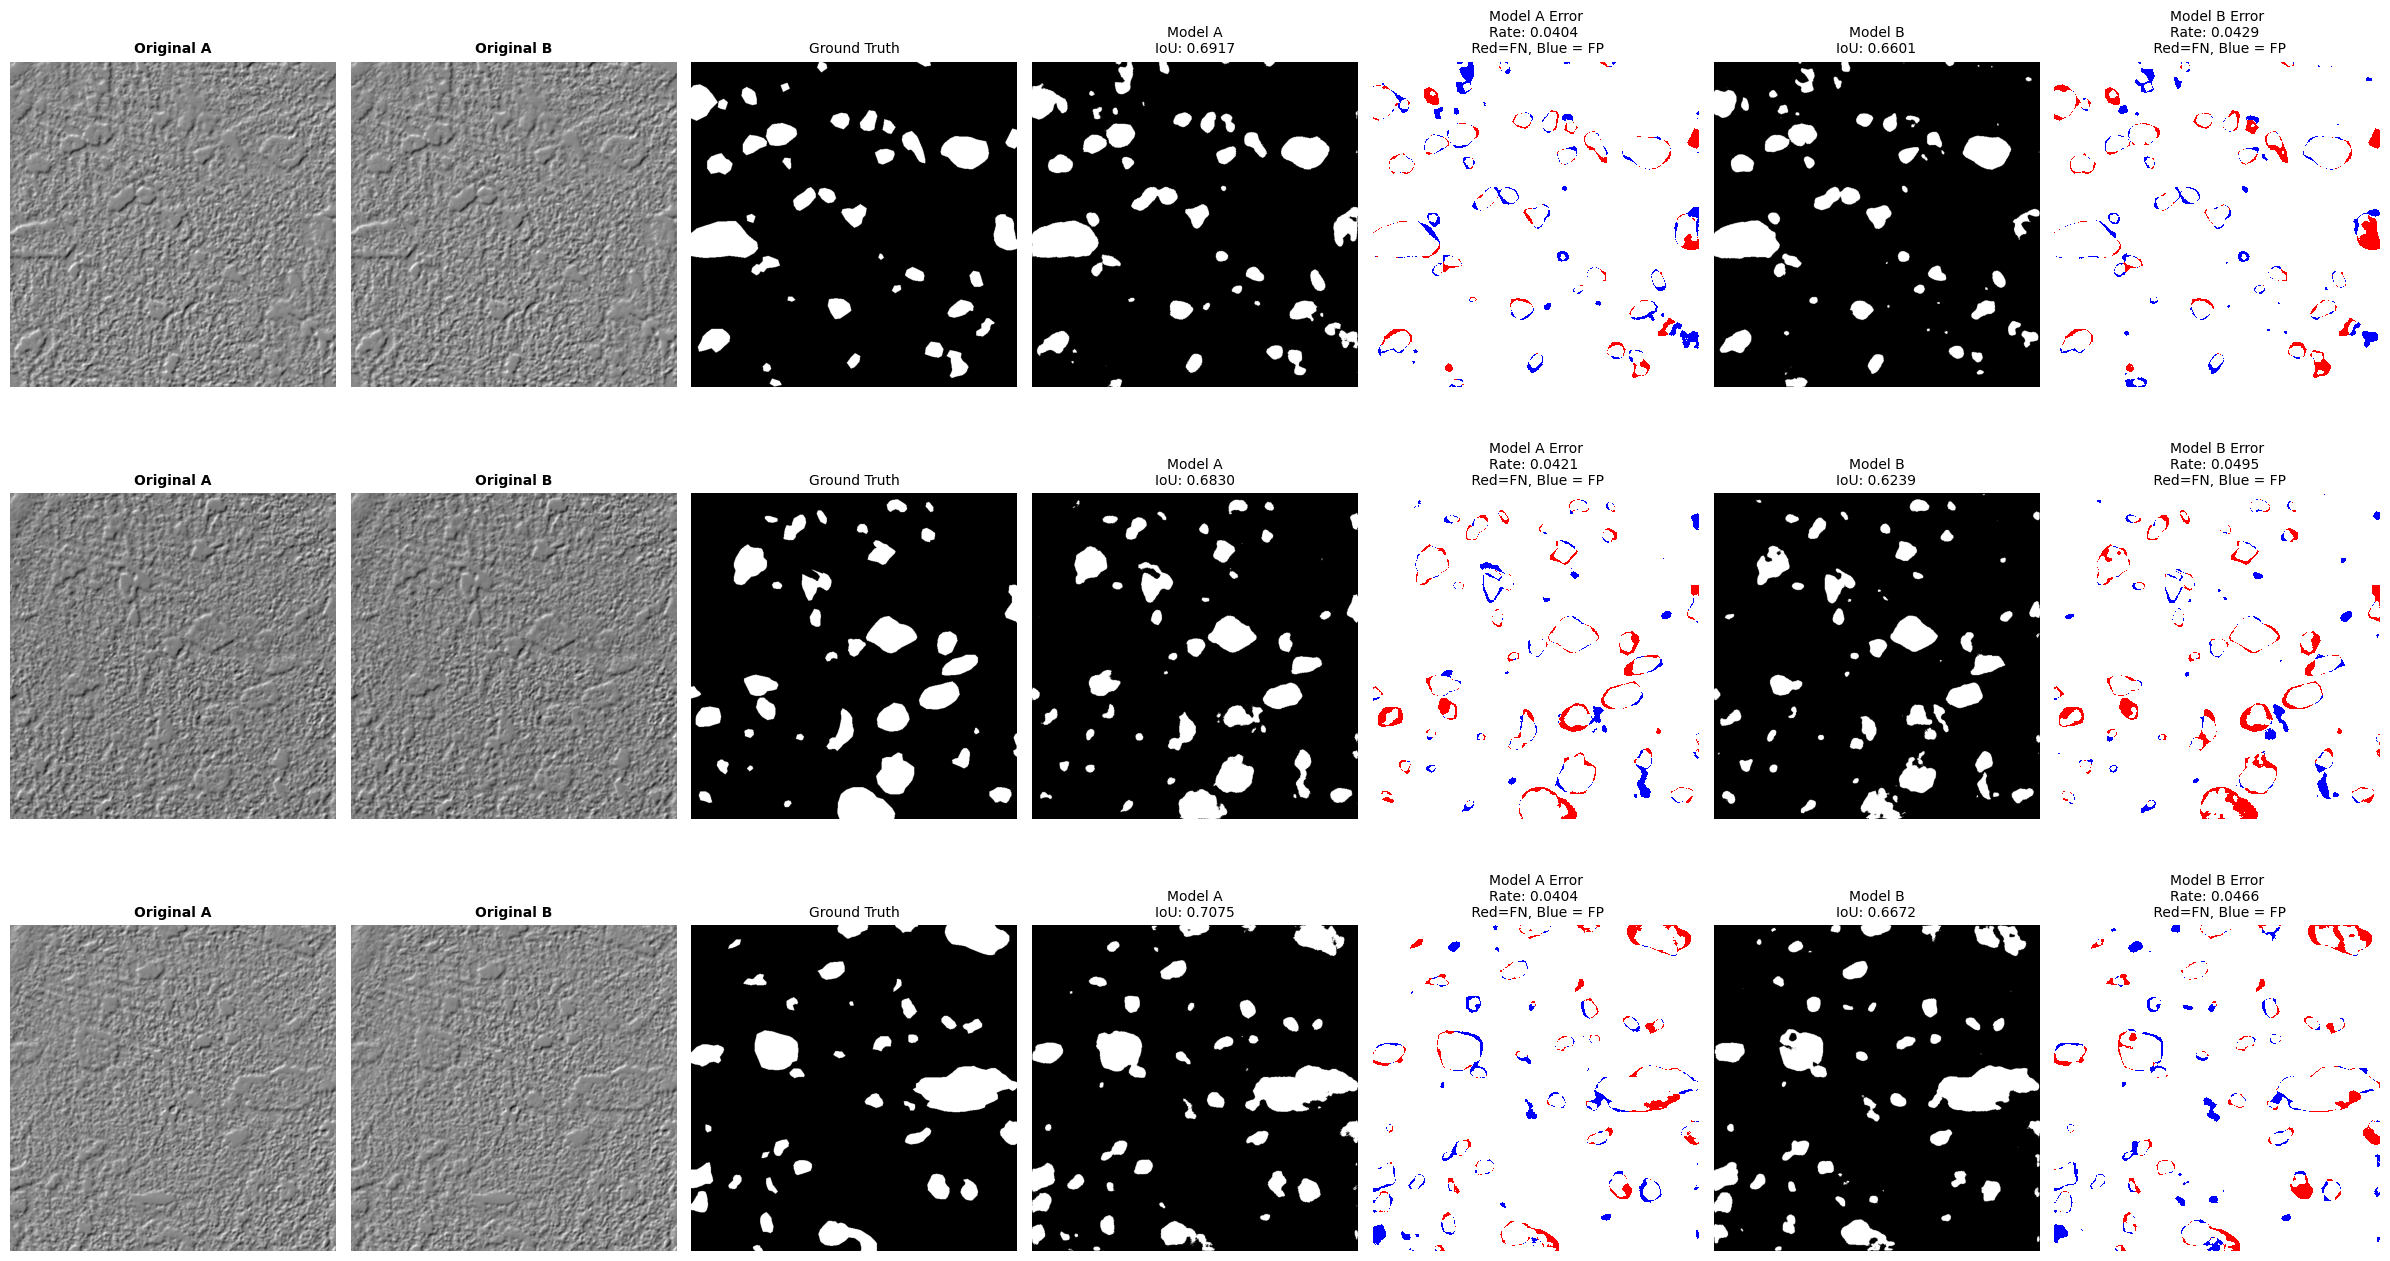

In [13]:
# Focal(alpha=0.25,gamma=2.0) + TverskyLoss( alpha=0.3, beta=0.7) vs Baseline

url = "https://github.com/maocili/Group15_Project21_02456/releases/download/v0.0.1/best_iou_Standard_loss_f_t_0.3_0.7_20251202_041128.pth"
ft_unet_path = helper.download_model(url)

ft_unet = UNet(in_channels=1, out_channels=2).to(device)
ft_unet.load_state_dict(torch.load(ft_unet_path, map_location=device, weights_only=True))

helper.visualize_comparison_validation(loader_A=denoise_loader, loader_B=denoise_loader,
                                       device=device, model_A=ft_unet, model_B=baseline_model)

File 'best_iou_Standard_loss_f_t_0.7_0.3_20251202_041345.pth' already exists. Skipping download.
torch.Size([3, 1, 768, 768]) torch.Size([3, 1, 768, 768])
Visualizing combined batch size: 3 (3 from A, 3 from B)
Figure saved to dual_loader_comparison.png


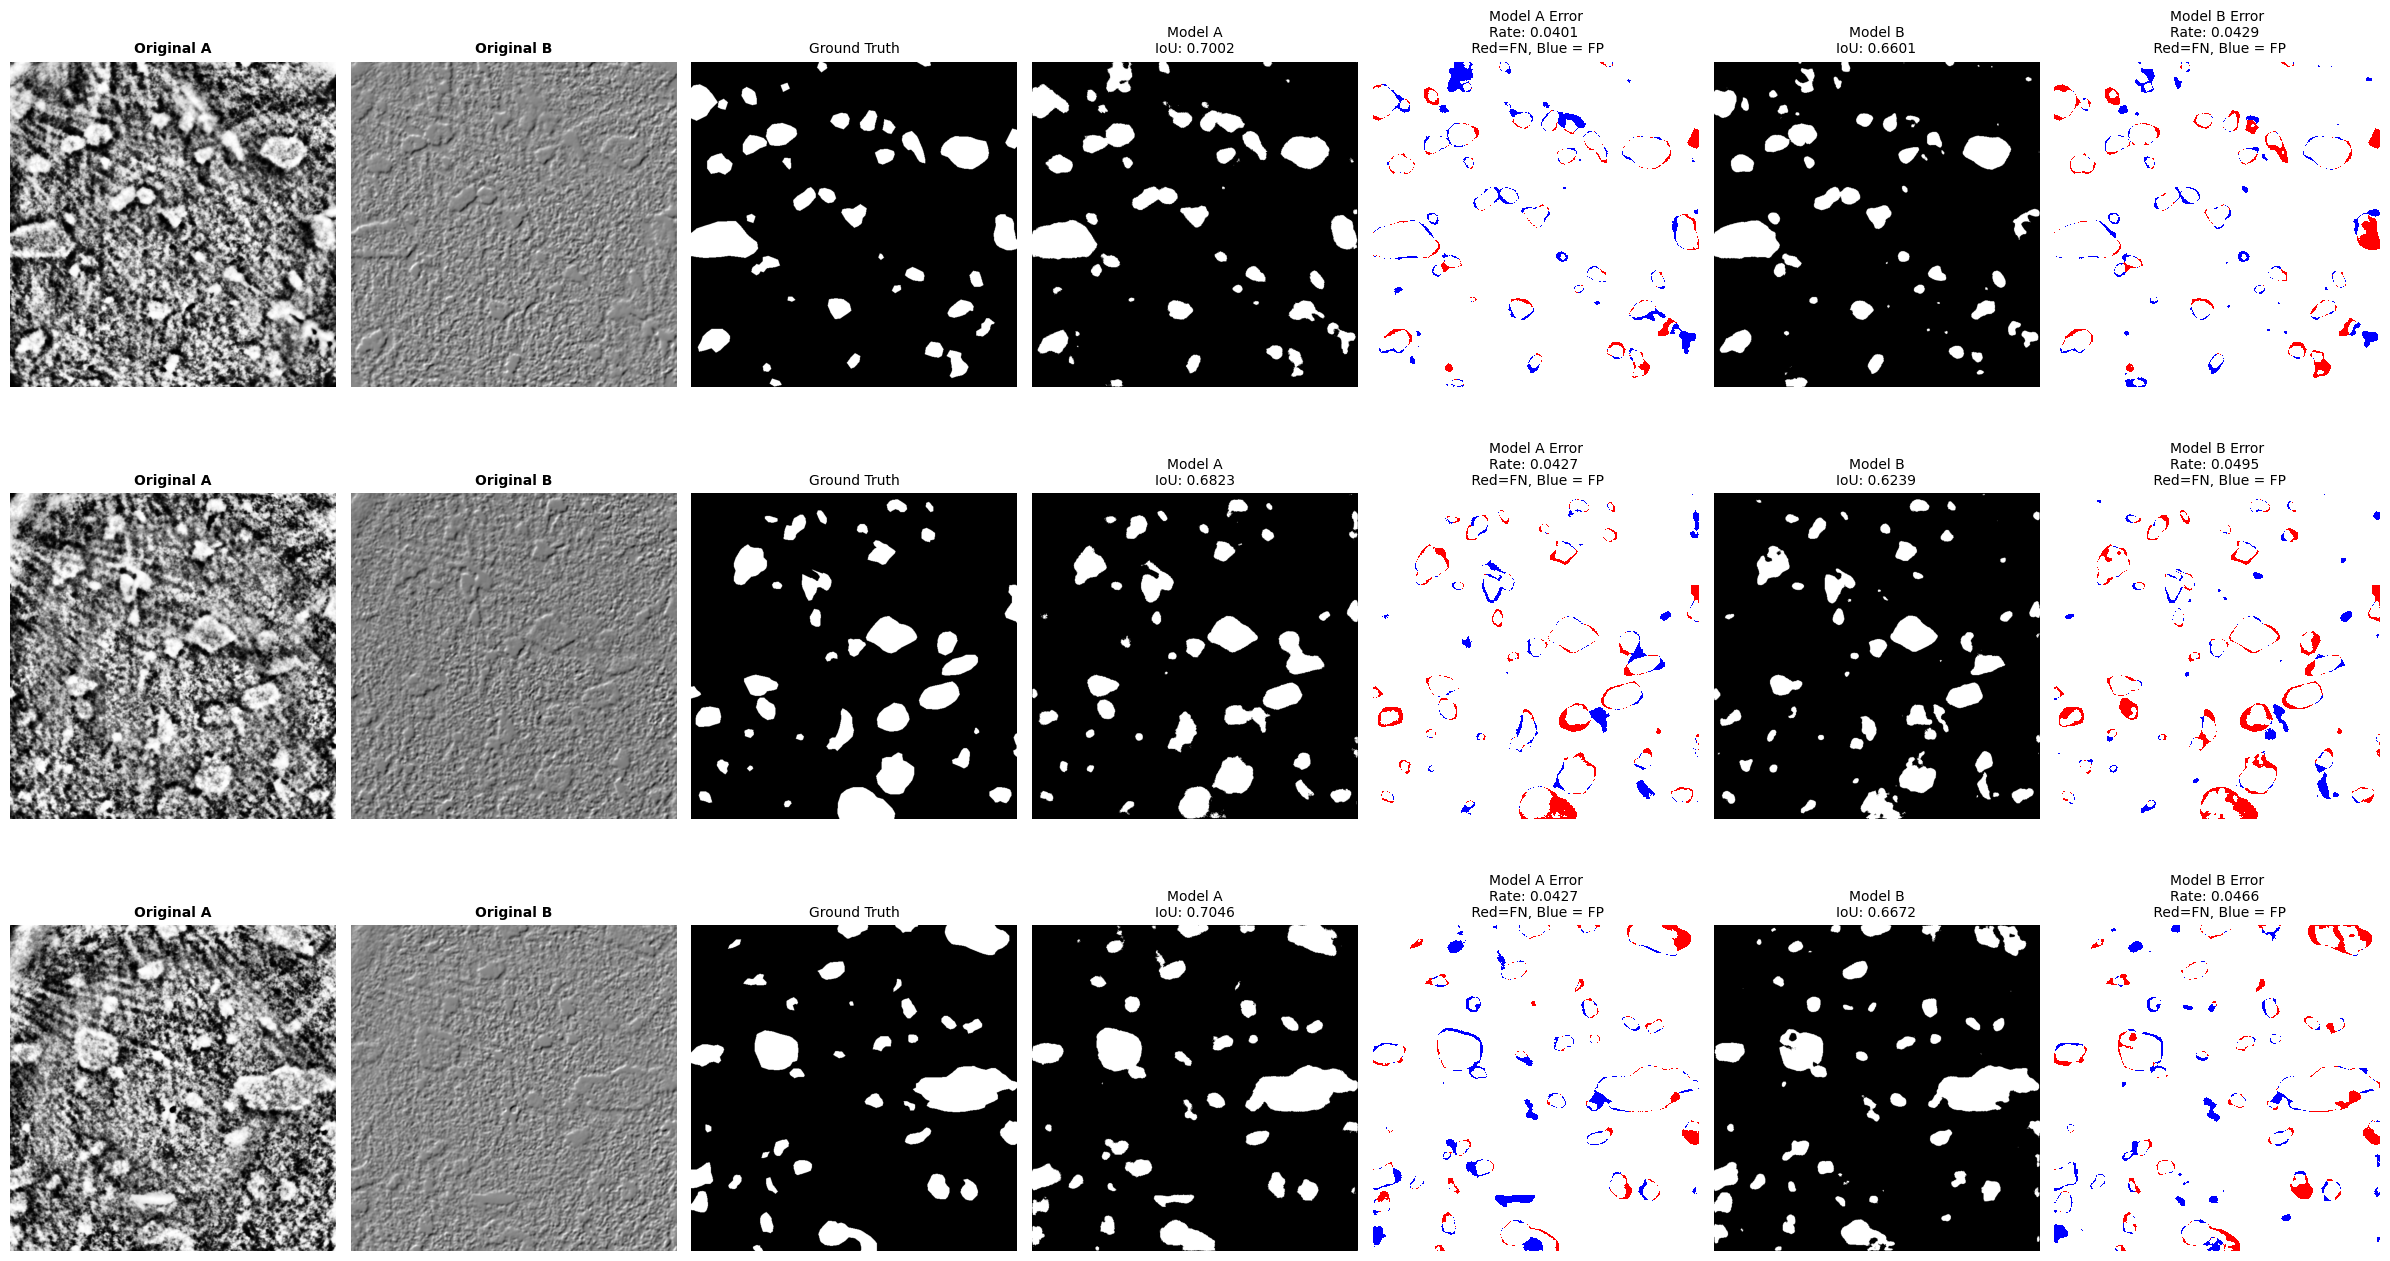

In [14]:
# Focal(alpha=0.25,gamma=2.0) + TverskyLoss( alpha=0.7, beta=0.3) vs Baseline

url = "https://github.com/maocili/Group15_Project21_02456/releases/download/v0.0.1/best_iou_Standard_loss_f_t_0.7_0.3_20251202_041345.pth"
ft_unet_path = helper.download_model(url)

ft_unet = UNet(in_channels=1, out_channels=2).to(device)
ft_unet.load_state_dict(torch.load(ft_unet_path, map_location=device, weights_only=True))

helper.visualize_comparison_validation(loader_A=raw_loader, loader_B=denoise_loader,
                                       device=device, model_A=ft_unet, model_B=baseline_model)

# Compare different loss functinos with IoU

In [15]:
ce_df = pd.read_csv("training_log/training_loss_ce_log_20251202_033557.csv")
ce_dice_df = pd.read_csv("training_log/training_loss_ce_dice_log_20251202_034620.csv")
f_logdice_df = pd.read_csv("training_log/training_loss_ce_logdice_log_20251202_040133.csv")
dice_df = pd.read_csv("training_log/training_dice_log_20251202_040325.csv")
baseline_df = pd.read_csv("training_log/training_km_pxiel_log_20251202_014629.csv")
f_t_37_df = pd.read_csv("training_log/training_loss_f_t_0.3_0.7_log_20251202_041128.csv")
f_t_73_df = pd.read_csv("training_log/training_loss_f_t_0.7_0.3_log_20251202_041345.csv")

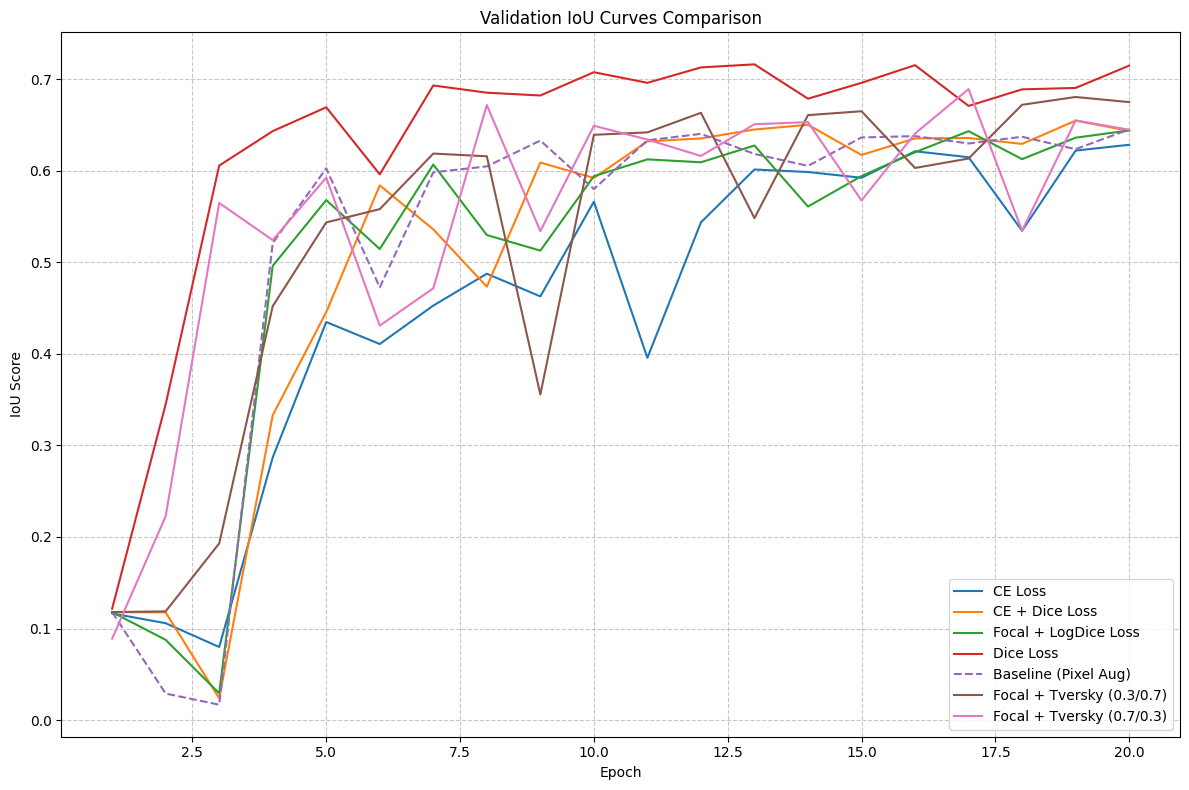

In [16]:
plt.figure(figsize=(12, 8))



plt.plot(ce_df['Epoch'], ce_df['Val_IoU'], label='CE Loss')
plt.plot(ce_dice_df['Epoch'], ce_dice_df['Val_IoU'], label='CE + Dice Loss')
plt.plot(f_logdice_df['Epoch'], f_logdice_df['Val_IoU'], label='Focal + LogDice Loss')
plt.plot(dice_df['Epoch'], dice_df['Val_IoU'], label='Dice Loss')
plt.plot(baseline_df['Epoch'], baseline_df['Val_IoU'], label='Baseline (Pixel Aug)', linestyle='--')
plt.plot(f_t_37_df['Epoch'], f_t_37_df['Val_IoU'], label='Focal + Tversky (0.3/0.7)')
plt.plot(f_t_73_df['Epoch'], f_t_73_df['Val_IoU'], label='Focal + Tversky (0.7/0.3)')

# 图表设置
plt.title('Validation IoU Curves Comparison')
plt.xlabel('Epoch')
plt.ylabel('IoU Score')
plt.legend(loc='lower right') # 图例放在右下角，避免遮挡曲线
plt.grid(True, linestyle='--', alpha=0.7)

# 显示图表
plt.tight_layout()
plt.show()